In [1]:
# import necessary libraries

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Function to calculate Entropy 

def entropy(y):
    hist = np.bincount(y)
    ps = hist/len(y)
    
    return (-np.sum([p*np.log2(p) for p in ps if p>0]))

In [3]:
# Node class representing a node in the decision tree

class Node:
    
    def __init__(self,feature=None,
                 threshold=None , left=None,right=None,*,value=None):
        
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    # Check if node is a leaf
    def is_leaf_node(self):
        return(self.value is not None)

In [21]:
# Decision Tree class

class DecisionTree:
    
    def __init__(self,min_samples_split=2,max_depth=100,n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        
    # Fit the DecisionTree on the training data
    def fit(self,X,y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats,X.shape[1])
        self.root = self._grow_tree(X,y)
        
    # Recursive function to grow the Decision Tree
    def _grow_tree(self,X,y,depth=0):
        n_samples , n_features = X.shape
        n_labels = len(np.unique(y))
        
        # Stopping criteris
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return(Node(value=leaf_value))
        
        feat_idxs = np.random.choice(n_features,self.n_feats,replace = False)
        
        # Greedy search for best split
        best_feat , best_thresh = self._best_criteria(X,y,feat_idxs)
        
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
        return(Node(best_feat, best_thresh, left, right))
    
    # Find the best split criteria
    def _best_criteria(self , X,y,feat_idxs):
        best_gain = -1
        split_idx , split_thresh = None,None
        for feat_idx in feat_idxs:
            X_column = X[:,feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y,X_column,threshold)
                if(gain > best_gain):
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return (split_idx , split_thresh)
    
    # Calculate information gain
    def _information_gain(self, y, X_column, split_thresh):

        # Parent entropy
        parent_entropy = entropy(y)

        # Generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if(len(left_idxs) == 0 or len(right_idxs) == 0):
            return 0

        # Weighted average child entropy
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l/n)*e_l + (n_r/n)*e_r

        # Return information gain
        ig = parent_entropy - child_entropy
        return ig

        # Split data into left and right indices
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return(left_idxs, right_idxs)

  # Predict class labels for input samples
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) if x is not None else 0 for x in X])

  # Recursively traverse the decision tree
    def _traverse_tree(self, x, node):
        if(node.is_leaf_node()):
            return(node.value)

        if(x[node.feature] <= node.threshold):
            return(self._traverse_tree(x, node.left))
            return(self._traverse_tree(x, node.right))

  # Find the most common label
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return(most_common)

# Function to calculate accuracy
    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return(accuracy)



In [22]:
def accuracy(y_true, y_pred):
    """
    Calculate accuracy of predictions.

    Parameters:
    y_true (array-like): True class labels.
    y_pred (array-like): Predicted class labels.

    Returns:
    float: Accuracy of predictions.
    """
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

Accuracy: 0.7982456140350878


<Axes: >

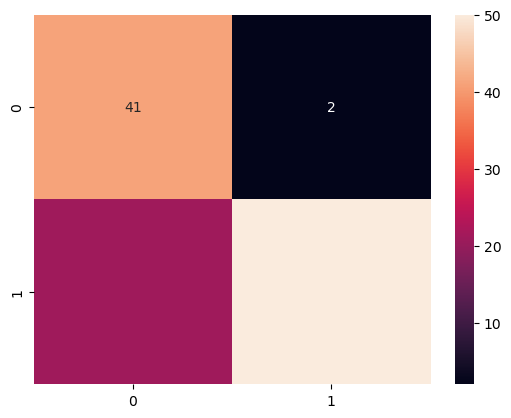

In [38]:
# Load dataset and split into train and test sets
data = datasets.load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train decision tree classifier
clf = DecisionTree(max_depth=20)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_pred = np.where(y_pred == None, 0, y_pred)
y_pred = y_pred.astype('int')

# Calculate accuracy
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

# Calculate and visualize confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True)

In [29]:
y_test

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0])